In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading in full data set
# brfss_total = pd.read_csv("../csv_data/brfss_total.csv")
brfss_total = pd.read_csv("./brfss_total.csv", index_col=0)

In [4]:
brfss_total.head()

,_STATE,DISPCODE,PHYSHLTH,MENTHLTH,USENOW3,HISPANC2,MARITAL,CHILDREN,EMPLOY,RENTHOM1,SEX,QLACTLM2,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
0,5.0,110.0,0.0,0.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,53.0,1.0,4.0,1.0,3.0,5.0,1.0
1,5.0,110.0,15.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,64.0,2.0,3.0,1.0,2.0,2.0,1.0
2,5.0,110.0,6.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,58.0,1.0,4.0,1.0,3.0,2.0,1.0
3,5.0,110.0,30.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,76.0,2.0,4.0,1.0,1.0,0.0,2.0
4,5.0,110.0,13.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,82.0,2.0,3.0,1.0,2.0,0.0,2.0


In [5]:
# just making sure no nulls are present
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117555 entries, 0 to 117554
Data columns (total 31 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _STATE    117555 non-null  float64
 1   DISPCODE  117555 non-null  float64
 2   PHYSHLTH  117555 non-null  float64
 3   MENTHLTH  117555 non-null  float64
 4   USENOW3   117555 non-null  float64
 5   HISPANC2  117555 non-null  float64
 6   MARITAL   117555 non-null  float64
 7   CHILDREN  117555 non-null  float64
 8   EMPLOY    117555 non-null  float64
 9   RENTHOM1  117555 non-null  float64
 10  SEX       117555 non-null  float64
 11  QLACTLM2  117555 non-null  float64
 12  ACEDEPRS  117555 non-null  float64
 13  ACEDRINK  117555 non-null  float64
 14  ACEDRUGS  117555 non-null  float64
 15  ACEPRISN  117555 non-null  float64
 16  ACEDIVRC  117555 non-null  float64
 17  ACEPUNCH  117555 non-null  float64
 18  ACEHURT   117555 non-null  float64
 19  ACESWEAR  117555 non-null  float64
 20  ACET

In [6]:
np.random.seed(151)

In [7]:
# creating X variable with all features
X_all = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [8]:
# creating the 4 y's
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [9]:
#original baseline for tobacco
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [10]:
#original baseline for activity
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [11]:
#original baseline for health
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [12]:
#original baseline for smoker
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [13]:
# splitting X up so I can do some engineering on the nominal data and ACE columns
X_num = X_all[['PHYSHLTH', 'MENTHLTH', 'CHILDREN']]
X_cat = X_all[['_STATE', 'DISPCODE', 'HISPANC2', 'MARITAL', 'EMPLOY', 'RENTHOM1', 'SEX', 'MSCODE', 
               '_IMPAGE', '_PRACE', '_EDUCAG', '_INCOMG','_TOTINDA']]
ace = X_all[['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [14]:
# updating ACE columns to be a count depending on the question
# first 5 questions are yes or no, so yes will be be counted as 1 and no will be counted as 0
# last 6 are questions of frequency, never = 0, once = 1, more than once = 2 (since not given an exact number)
ace['ACEDEPRS'] = ace['ACEDEPRS'].map({1:1, 2:0, 0:0})
ace['ACEDRINK'] = ace['ACEDRINK'].map({1:1, 2:0, 0:0})
ace['ACEDRUGS'] = ace['ACEDRUGS'].map({1:1, 2:0, 0:0})
ace['ACEPRISN'] = ace['ACEPRISN'].map({1:1, 2:0, 0:0})
ace['ACEDIVRC'] = ace['ACEDIVRC'].map({1:1, 2:0, 0:0})
ace['ACEPUNCH'] = ace['ACEPUNCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHURT'] = ace['ACEHURT'].map({1:0, 2:1, 3:2, 0:0})
ace['ACESWEAR'] = ace['ACESWEAR'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETOUCH'] = ace['ACETOUCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETTHEM'] = ace['ACETTHEM'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHVSEX'] = ace['ACEHVSEX'].map({1:0, 2:1, 3:2, 0:0})

In [15]:
# creating a column for counting the number of ACEs an individual had
X_num['ACE_Count'] = ace.sum(axis = 1)

In [16]:
# turning the nominal columns into strings so they can be dummified
X_cat = X_cat.astype(str)

In [17]:
# dummifying nominal variables for X_all
X_dummies = pd.get_dummies(X_cat, drop_first=True)
X_dummies.head()

,_STATE_15.0,_STATE_19.0,_STATE_22.0,_STATE_27.0,_STATE_30.0,_STATE_32.0,_STATE_37.0,_STATE_40.0,_STATE_47.0,_STATE_5.0,_STATE_50.0,_STATE_53.0,_STATE_55.0,DISPCODE_1100.0,DISPCODE_120.0,DISPCODE_1200.0,HISPANC2_1.0,HISPANC2_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,EMPLOY_1.0,EMPLOY_2.0,EMPLOY_3.0,EMPLOY_4.0,EMPLOY_5.0,EMPLOY_6.0,RENTHOM1_1.0,RENTHOM1_2.0,RENTHOM1_3.0,SEX_2.0,MSCODE_1.0,MSCODE_2.0,MSCODE_3.0,MSCODE_5.0,_IMPAGE_18.0,_IMPAGE_19.0,...,_IMPAGE_74.0,_IMPAGE_75.0,_IMPAGE_76.0,_IMPAGE_78.0,_IMPAGE_79.0,_IMPAGE_80.0,_IMPAGE_81.0,_IMPAGE_82.0,_IMPAGE_83.0,_IMPAGE_84.0,_IMPAGE_85.0,_IMPAGE_86.0,_IMPAGE_87.0,_IMPAGE_89.0,_IMPAGE_90.0,_IMPAGE_91.0,_IMPAGE_92.0,_IMPAGE_93.0,_IMPAGE_94.0,_IMPAGE_95.0,_IMPAGE_96.0,_IMPAGE_97.0,_IMPAGE_98.0,_PRACE_1.0,_PRACE_2.0,_PRACE_3.0,_PRACE_4.0,_PRACE_5.0,_PRACE_6.0,_EDUCAG_1.0,_EDUCAG_2.0,_EDUCAG_3.0,_EDUCAG_4.0,_INCOMG_1.0,_INCOMG_2.0,_INCOMG_3.0,_INCOMG_4.0,_INCOMG_5.0,_TOTINDA_1.0,_TOTINDA_2.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [18]:
X_num.head()

,PHYSHLTH,MENTHLTH,CHILDREN,ACE_Count
0,0.0,0.0,1.0,0
1,15.0,0.0,0.0,3
2,6.0,0.0,0.0,0
3,30.0,0.0,0.0,0
4,13.0,0.0,0.0,0


In [19]:
# merging numerical and nominal data into one data frame
X_all = X_num.merge(X_dummies, left_index=True, right_index=True)

In [20]:
X_all.shape

(117555, 138)

In [21]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X_all1, y_tobacco = sm.fit_resample(X_all, y_tobacco)

sm2 = SMOTE(random_state=151)
X_all2, y_activity = sm2.fit_resample(X_all, y_activity)

sm3 = SMOTE(random_state=151)
X_all3, y_health = sm3.fit_resample(X_all, y_health)

sm4 = SMOTE(random_state=151)
X_all4, y_smoker = sm4.fit_resample(X_all, y_smoker)

In [ ]:
#y_tobacco.value_counts(normalize=True)

In [ ]:
#y_activity.value_counts(normalize=True)

In [ ]:
#y_health.value_counts(normalize=True)

In [ ]:
#y_smoker.value_counts(normalize=True)

In [22]:
# looks like with SMOTE resampling, data set has increased about 4x
X_all1.shape

(454496, 138)

In [23]:
# creating training and testing sets for all y's
X_train_all, X_test_all, y_train_tobacco, y_test_tobacco = train_test_split(X_all1, y_tobacco, random_state = 151, stratify=y_tobacco)
X_train_all2, X_test_all2, y_train_activity, y_test_activity = train_test_split(X_all2, y_activity, random_state = 151, stratify=y_activity)
X_train_all3, X_test_all3, y_train_health, y_test_health = train_test_split(X_all3, y_health, random_state = 151, stratify=y_health)
X_train_all4, X_test_all4, y_train_smoker, y_test_smoker = train_test_split(X_all4, y_smoker, random_state = 151, stratify=y_smoker)

In [24]:
X_train_all.shape

(340872, 138)

In [25]:
y_train_tobacco.shape

(340872,)

In [26]:
pipe_all_tobacco = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300))
pipe_all_tobacco.fit(X_train_all, y_train_tobacco)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [27]:
pipe_all_activity = make_pipeline(SelectKBest(f_classif, k=136), StandardScaler(), ExtraTreesClassifier(max_depth=None, n_estimators=500))
pipe_all_activity.fit(X_train_all2, y_train_activity)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=136,
                             score_func=<function f_classif at 0x7fd8b7a88d90>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=None,
                                   

In [28]:
pipe_all_health = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=100))
pipe_all_health.fit(X_train_all3, y_train_health)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fd8b7a88d90>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                

In [29]:
pipe_all_smoker = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=500))
pipe_all_smoker.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fd8b7a88d90>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                

In [30]:
# getting predictions for each model
tobacco_all_preds = pipe_all_tobacco.predict(X_test_all)
activity_all_preds = pipe_all_activity.predict(X_test_all2)
health_all_preds = pipe_all_health.predict(X_test_all3)
smoker_all_preds = pipe_all_smoker.predict(X_test_all4)

# calculating the precision score for each model
tobacco_all_prec = precision_score(y_test_tobacco, tobacco_all_preds, average='micro')
activity_all_prec = precision_score(y_test_activity, activity_all_preds, average='micro')
health_all_prec = precision_score(y_test_health, health_all_preds, average='micro')
smoker_all_prec = precision_score(y_test_smoker, smoker_all_preds, average='micro')

In [31]:
print(f'training accuracy for tobacco w/ACE grouped: {cross_val_score(pipe_all_tobacco, X_train_all, y_train_tobacco, cv=3).mean()}')
print(f'testing accuracy for tobacco w/ACE grouped: {cross_val_score(pipe_all_tobacco, X_test_all, y_test_tobacco, cv=3).mean()}')
print(f'Precision for tobacco w/ACE grouped: {tobacco_all_prec}')

 training accuracy for tobacco w/ACE grouped: 0.9921524795231055
 testing accuracy for tobacco w/ACE grouped: 0.9871505963291054
Precision for tobacco w/ACE grouped: 0.9920967401253257


In [32]:
print(f'training accuracy for activity w/ACE grouped: {cross_val_score(pipe_all_activity, X_train_all2, y_train_activity, cv=3).mean()}')
print(f'testing accuracy for activity w/ACE grouped: {cross_val_score(pipe_all_activity, X_test_all2, y_test_activity, cv=3).mean()}')
print(f'Precision for activity w/ACE grouped: {activity_all_prec}')

 training accuracy for activity w/ACE grouped: 0.9088888193118132
 testing accuracy for activity w/ACE grouped: 0.8817451744704833
Precision for activity w/ACE grouped: 0.9155591039308693


In [33]:
print(f'training accuracy for health w/ACE grouped: {cross_val_score(pipe_all_health, X_train_all3, y_train_health, cv=3).mean()}')
print(f'testing accuracy for health w/ACE grouped: {cross_val_score(pipe_all_health, X_test_all3, y_test_health, cv=3).mean()}')
print(f'Precision for health w/ACE grouped: {health_all_prec}')

 training accuracy for health w/ACE grouped: 0.9433080630846032
 testing accuracy for health w/ACE grouped: 0.9310205646543404
Precision for health w/ACE grouped: 0.9453454540392299


In [34]:
print(f'training accuracy for smoker w/ACE grouped: {cross_val_score(pipe_all_smoker, X_train_all4, y_train_smoker, cv=3).mean()}')
print(f'testing accuracy for smoker w/ACE grouped: {cross_val_score(pipe_all_smoker,X_test_all4, y_test_smoker, cv=3).mean()}')
print(f'Precision for smoker w/ACE grouped: {smoker_all_prec}')

 training accuracy for smoker w/ACE grouped: 0.7801176915750055
 testing accuracy for smoker w/ACE grouped: 0.709519563523612
Precision for smoker w/ACE grouped: 0.8006967459095535


In [35]:
# getting features importances for smokeless tobacco use
tobacco_all = pd.DataFrame({'features': X_all.columns.values, 'importance':pipe_all_tobacco.named_steps['randomforestclassifier'].feature_importances_})
tobacco_all = tobacco_all.sort_values('importance', ascending = False)

# looking at top 10
tobacco_all.head(10)

,features,importance
12,_STATE_47.0,0.105485
37,SEX_2.0,0.083121
3,ACE_Count,0.056033
17,DISPCODE_1100.0,0.049042
34,RENTHOM1_1.0,0.032145
28,EMPLOY_1.0,0.026223
38,MSCODE_1.0,0.022191
2,CHILDREN,0.020242
135,_INCOMG_5.0,0.019619
130,_EDUCAG_4.0,0.019582


In [36]:
# looking at last 10
tobacco_all.tail(10)

,features,importance
107,_IMPAGE_84.0,4.134442e-04
111,_IMPAGE_89.0,3.427955e-04
109,_IMPAGE_86.0,2.584162e-04
114,_IMPAGE_92.0,1.442131e-04
115,_IMPAGE_93.0,1.324313e-04
117,_IMPAGE_95.0,4.619060e-05
116,_IMPAGE_94.0,2.273391e-06
120,_IMPAGE_98.0,1.983613e-06
118,_IMPAGE_96.0,1.174570e-06
119,_IMPAGE_97.0,8.927631e-07


**Looks like being an senior citizen has the least amount of influence on smokeless tobacco usage**

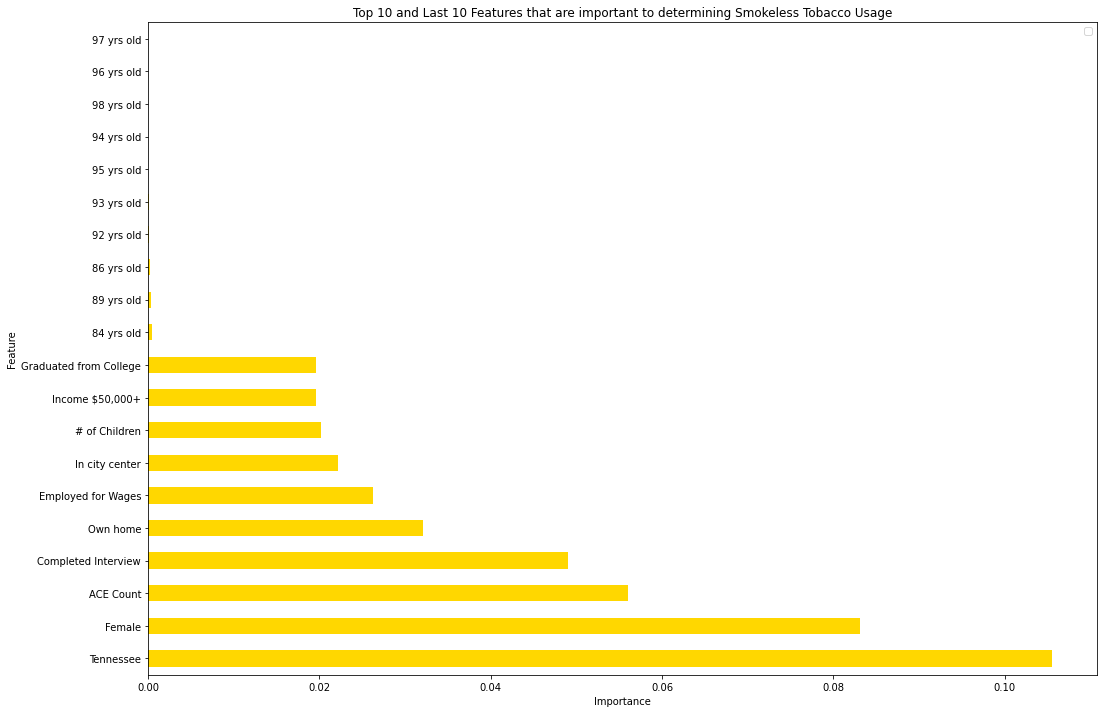

In [37]:
def top_bottom(df, color, labels):
  ''' Function to graph Top 10 and Last 10 Features based on importance'''
  full_df = pd.merge(df.head(10), df.tail(10), how='outer')
  full_df.plot(kind='barh', figsize=(17, 12), color=color)
  plt.yticks(ticks=full_df.index, labels=labels)
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.legend([]);
  return

top_bottom(tobacco_all, color = 'gold', labels=['Tennessee', 'Female', 'ACE Count', 'Completed Interview', 'Own home', 
            'Employed for Wages', 'In city center', '# of Children', 
            'Income $50,000+', 'Graduated from College',
            '84 yrs old', '89 yrs old', '86 yrs old', '92 yrs old', '93 yrs old',
            '95 yrs old', '94 yrs old', '98 yrs old', '96 yrs old', '97 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Smokeless Tobacco Usage');

plt.savefig('tobacco.jpg')

In [38]:
# getting features selected by 'selectkbest' for other three y's
features_activity_all = pipe_all_activity.named_steps['selectkbest'].get_support(indices=True) 
features_health_all = pipe_all_health.named_steps['selectkbest'].get_support(indices=True) 
features_smoker_all = pipe_all_smoker.named_steps['selectkbest'].get_support(indices=True) 

In [39]:
# getting column names for features selected by 'selectkbest' for other three y's
X_cols_activity_all = X_all.columns.values[features_activity_all]
X_cols_health_all = X_all.columns.values[features_health_all]
X_cols_smoker_all = X_all.columns.values[features_smoker_all]

In [40]:
# getting each feature's importance for other three y's
coefs_activity_all = pipe_all_activity.named_steps['extratreesclassifier'].feature_importances_
coefs_health_all = pipe_all_health.named_steps['randomforestclassifier'].feature_importances_
coefs_smoker_all = pipe_all_smoker.named_steps['randomforestclassifier'].feature_importances_

In [41]:
# feature importances for activity limitations
activity_all = pd.DataFrame({'features': X_cols_activity_all, 'importance':coefs_activity_all})
activity_all = activity_all.sort_values('importance', ascending = False)
activity_all.head(10)

,features,importance
0,PHYSHLTH,0.064875
12,_STATE_47.0,0.044570
28,EMPLOY_1.0,0.043460
3,ACE_Count,0.035963
34,RENTHOM1_1.0,0.032924
133,_INCOMG_5.0,0.029446
1,MENTHLTH,0.027759
37,SEX_2.0,0.024443
17,DISPCODE_1100.0,0.022504
22,MARITAL_1.0,0.020054


In [42]:
activity_all.tail(10)

,features,importance
47,_IMPAGE_23.0,0.000704
49,_IMPAGE_25.0,0.000692
42,_IMPAGE_18.0,0.000667
44,_IMPAGE_20.0,0.000644
43,_IMPAGE_19.0,0.000639
19,DISPCODE_1200.0,0.000567
116,_IMPAGE_95.0,0.000546
118,_IMPAGE_98.0,0.000274
115,_IMPAGE_94.0,0.000169
117,_IMPAGE_96.0,0.000088


**Looks like being very young or very old doesn't have much affect on activity limitations, nor does not finishing the survey in its entirety**

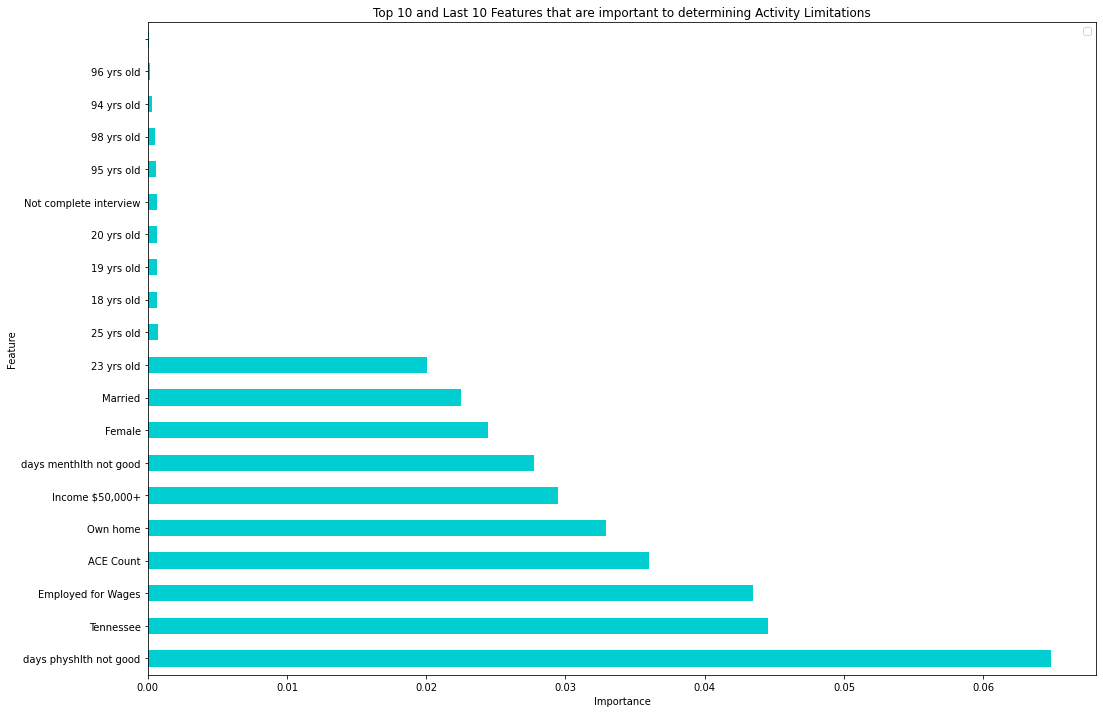

In [43]:
top_bottom(activity_all, color='darkturquoise', labels = ['days physhlth not good', 'Tennessee', 
                                                          'Employed for Wages', 'ACE Count', 'Own home', 
                                                          'Income $50,000+', 'days menthlth not good',
                                                          'Female', 'Married','23 yrs old', '25 yrs old', '18 yrs old',
                                                          '19 yrs old', '20 yrs old', 'Not complete interview',
                                                          '95 yrs old', '98 yrs old', '94 yrs old', '96 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Activity Limitations');

plt.savefig('activity.jpg')

In [44]:
# feature importances for self-reported health
health_all = pd.DataFrame({'features': X_cols_health_all, 'importance':coefs_health_all})
health_all = health_all.sort_values('importance', ascending = False)
health_all.head(10)

,features,importance
0,PHYSHLTH,0.097954
25,EMPLOY_1.0,0.047515
3,ACE_Count,0.041742
103,_INCOMG_5.0,0.038762
1,MENTHLTH,0.036171
99,_EDUCAG_4.0,0.029424
33,SEX_2.0,0.028227
30,RENTHOM1_1.0,0.027995
105,_TOTINDA_2.0,0.027984
104,_TOTINDA_1.0,0.025009


In [45]:
health_all.tail(10)

,features,importance
93,_PRACE_4.0,0.000676
43,_IMPAGE_27.0,0.000651
86,_IMPAGE_90.0,0.000595
47,_IMPAGE_31.0,0.000566
39,_IMPAGE_21.0,0.000528
42,_IMPAGE_24.0,0.000487
46,_IMPAGE_30.0,0.000465
38,_IMPAGE_20.0,0.000324
40,_IMPAGE_22.0,0.000321
37,_IMPAGE_18.0,0.000303


**Looks like a few ages don't have a big influence on perceived health, nor does being Native Hawaiian or other Pacific Islander**

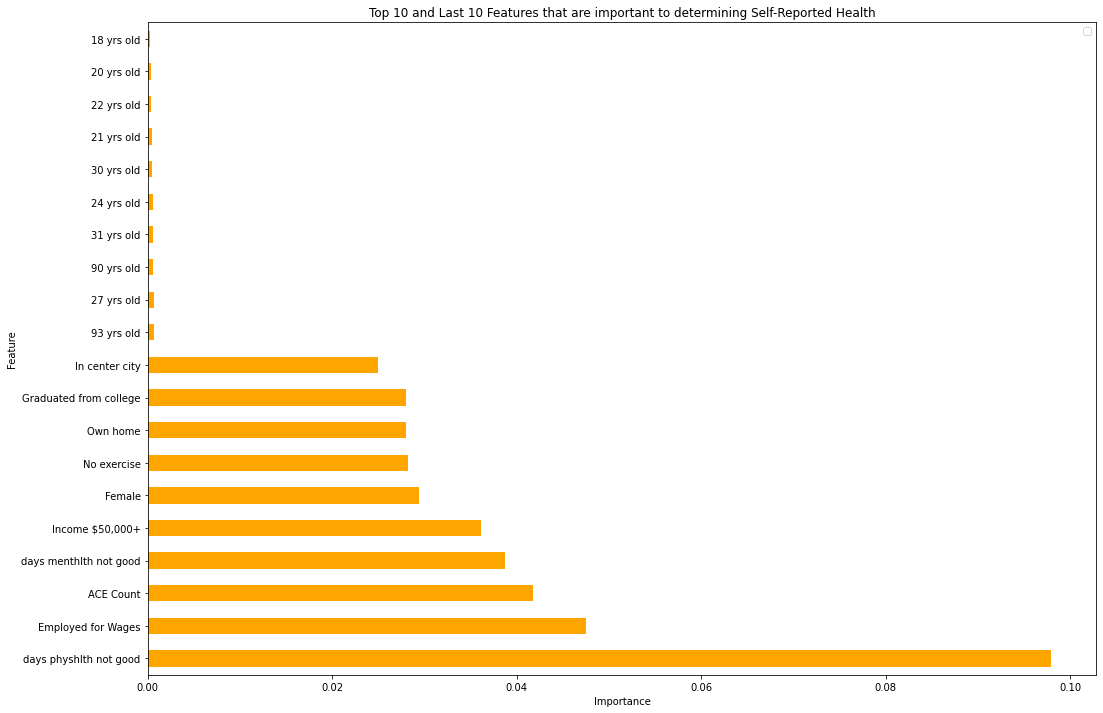

In [46]:
top_bottom(health_all, color = 'orange', labels = ['days physhlth not good', 'Employed for Wages',
                                                           'ACE Count', 'days menthlth not good',
                                                           'Income $50,000+','Female', 'No exercise',
                                                           'Own home', 'Graduated from college', 
                                                           'In center city','93 yrs old', '27 yrs old', '90 yrs old',
                                                           '31 yrs old', '24 yrs old', '30 yrs old', '21 yrs old',
                                                           '22 yrs old', '20 yrs old', '18 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Self-Reported Health');

plt.savefig('health.jpg')

In [47]:
# feature importances for smoker status
smoker_all = pd.DataFrame({'features': X_cols_smoker_all, 'importance':coefs_smoker_all})
smoker_all = smoker_all.sort_values('importance', ascending = False)
smoker_all.head(10)

,features,importance
3,ACE_Count,0.070039
0,PHYSHLTH,0.039284
1,MENTHLTH,0.036018
11,_STATE_47.0,0.035014
33,SEX_2.0,0.031330
2,CHILDREN,0.028582
24,EMPLOY_1.0,0.027787
30,RENTHOM1_1.0,0.026616
36,MSCODE_5.0,0.023771
15,DISPCODE_1100.0,0.023718


In [48]:
smoker_all.tail(10)

,features,importance
44,_IMPAGE_25.0,0.001402
86,_IMPAGE_87.0,0.001280
39,_IMPAGE_20.0,0.001140
40,_IMPAGE_21.0,0.001119
38,_IMPAGE_19.0,0.001086
85,_IMPAGE_86.0,0.001064
87,_IMPAGE_90.0,0.000975
37,_IMPAGE_18.0,0.000905
89,_IMPAGE_92.0,0.000902
88,_IMPAGE_91.0,0.000483


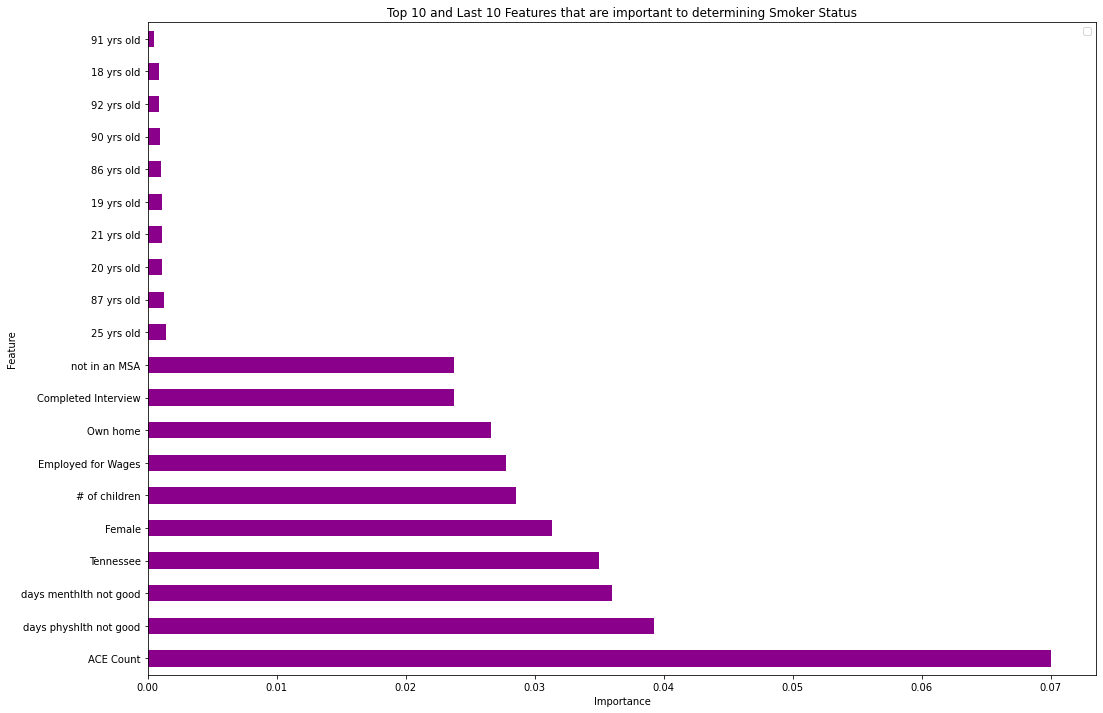

In [49]:
top_bottom(smoker_all, color='darkmagenta', labels = ['ACE Count','days physhlth not good', 'days menthlth not good',
                                                      'Tennessee', 'Female', '# of children', 'Employed for Wages', 'Own home',
                                                      'Completed Interview', 'not in an MSA', '25 yrs old', '87 yrs old', '20 yrs old',
                                                           '21 yrs old', '19 yrs old', '86 yrs old', '90 yrs old',
                                                           '92 yrs old', '18 yrs old', '91 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Smoker Status');

plt.savefig('smoker.jpg')

**Looks like a few ages don't have a big influence on smoker status**

In [50]:
X_ace = X_num[['ACE_Count']]

In [51]:
X_ace.head()

,ACE_Count
0,0
1,3
2,0
3,0
4,0


In [52]:
# creating the 4 y's for ACE count only
y_tobacco_ace = brfss_total['USENOW3']
y_activity_ace = brfss_total['QLACTLM2']
y_health_ace = brfss_total['_RFHLTH']
y_smoker_ace = brfss_total['_SMOKER3']

In [53]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X1, y_tobacco_ace = sm.fit_resample(X_ace, y_tobacco_ace)

sm2 = SMOTE(random_state=151)
X2, y_activity_ace = sm2.fit_resample(X_ace, y_activity_ace)

sm3 = SMOTE(random_state=151)
X3, y_health_ace = sm3.fit_resample(X_ace, y_health_ace)

sm4 = SMOTE(random_state=151)
X4, y_smoker_ace = sm4.fit_resample(X_ace, y_smoker_ace)

In [54]:
X1.shape

(454496, 1)

In [55]:
# creating training and testing sets for all ACE count y's 
X_train_ace, X_test_ace, y_train_tobacco_ace, y_test_tobacco_ace = train_test_split(X1, y_tobacco_ace, random_state = 151, stratify=y_tobacco_ace)
X_train_ace2, X_test_ace2, y_train_activity_ace, y_test_activity_ace = train_test_split(X2, y_activity_ace, random_state = 151, stratify=y_activity_ace)
X_train_ace3, X_test_ace3, y_train_health_ace, y_test_health_ace = train_test_split(X3, y_health_ace, random_state = 151, stratify=y_health_ace)
X_train_ace4, X_test_ace4, y_train_smoker_ace, y_test_smoker_ace = train_test_split(X4, y_smoker_ace, random_state = 151, stratify=y_smoker_ace)

In [56]:
ace_tobacco = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 3, n_estimators = 20)
ace_tobacco.fit(X_train_ace, y_train_tobacco_ace)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [57]:
ace_activity = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100)
ace_activity.fit(X_train_ace2, y_train_activity_ace)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
ace_health = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500)
ace_health.fit(X_train_ace3, y_train_health_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [59]:
ace_smoker = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300)
ace_smoker.fit(X_train_ace4, y_train_smoker_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [60]:
tobacco_ace_preds = ace_tobacco.predict(X_test_ace)
activity_ace_preds = ace_activity.predict(X_test_ace2)
health_ace_preds = ace_health.predict(X_test_ace3)
smoker_ace_preds = ace_smoker.predict(X_test_ace4)

tobacco_ace_prec = precision_score(y_test_tobacco_ace, tobacco_ace_preds, average='micro')
activity_ace_prec = precision_score(y_test_activity_ace, activity_ace_preds, average='micro')
health_ace_prec = precision_score(y_test_health_ace, health_ace_preds, average='micro')
smoker_ace_prec = precision_score(y_test_smoker_ace, smoker_ace_preds, average='micro')

In [61]:
print(f'training accuracy for tobacco w/ACE Grouped: {cross_val_score(ace_tobacco, X_train_ace, y_train_tobacco_ace, cv=3).mean()}')
print(f'testing accuracy for tobacco w/ACE Grouped: {cross_val_score(ace_tobacco, X_test_ace, y_test_tobacco_ace, cv=3).mean()}')
print(f'Precision for tobacco: {tobacco_ace_prec}')

training accuracy for tobacco w/ACE Grouped: 0.3884331948649346
testing accuracy for tobacco w/ACE Grouped: 0.38648523455080896
Precision for tobacco: 0.3859131873547842


In [62]:
print(f'training accuracy for activity w/ACE Grouped: {cross_val_score(ace_activity, X_train_ace2, y_train_activity_ace, cv=3).mean()}')
print(f'testing accuracy for activity w/ACE Grouped: {cross_val_score(ace_activity, X_test_ace2, y_test_activity_ace, cv=3).mean()}')
print(f'Precision for activity: {activity_ace_prec}')

training accuracy for activity w/ACE Grouped: 0.4146498011835061
testing accuracy for activity w/ACE Grouped: 0.41714804552356793
Precision for activity: 0.417148045523568


In [63]:
print(f'training accuracy for health w/ACE Grouped: {cross_val_score(ace_health, X_train_ace3, y_train_health_ace, cv=3).mean()}')
print(f'testing accuracy for health w/ACE Grouped: {cross_val_score(ace_health, X_test_ace3, y_test_health_ace, cv=3).mean()}')
print(f'Precision for health: {health_ace_prec}')

training accuracy for health w/ACE Grouped: 0.3711913904046252
testing accuracy for health w/ACE Grouped: 0.3770551369589761
Precision for health: 0.3759692620383389


In [64]:
print(f'training accuracy for smoker w/ACE Grouped: {cross_val_score(ace_smoker, X_train_ace4, y_train_smoker_ace, cv=3).mean()}')
print(f'testing accuracy for smoker w/ACE Grouped: {cross_val_score(ace_smoker, X_test_ace4, y_test_smoker_ace, cv=3).mean()}')
print(f'Precision for smoker: {smoker_ace_prec}')

training accuracy for smoker w/ACE Grouped: 0.27220417270129565
testing accuracy for smoker w/ACE Grouped: 0.27107854926750075
Precision for smoker: 0.27195271522141906




---




**Since we're only looking at one feature, the amount of ACEs someone had, to predict the y's, I believe logistic regression to be the best course of action when modeling. It is simple and easy to understand, something that is an asset when talking about such a sensitive topic. Also, the accuracy and precision for each y is comprable to those for the ensemble models above.**

---



In [65]:
ace_tobacco_lr = LogisticRegression(C=0.01)
ace_tobacco_lr.fit(X_train_ace, y_train_tobacco_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
ace_activity_lr = LogisticRegression(C=0.01)
ace_activity_lr.fit(X_train_ace2, y_train_activity_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
ace_health_lr = LogisticRegression(C=0.01)
ace_health_lr.fit(X_train_ace3, y_train_health_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
ace_smoker_lr = LogisticRegression(C=0.01)
ace_smoker_lr.fit(X_train_ace4, y_train_smoker_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
tobacco_ace_preds_lr = ace_tobacco_lr.predict(X_test_ace)
activity_ace_preds_lr = ace_activity_lr.predict(X_test_ace2)
health_ace_preds_lr = ace_health_lr.predict(X_test_ace3)
smoker_ace_preds_lr = ace_smoker_lr.predict(X_test_ace4)

tobacco_ace_prec_lr = precision_score(y_test_tobacco_ace, tobacco_ace_preds_lr, average='micro')
activity_ace_prec_lr = precision_score(y_test_activity_ace, activity_ace_preds_lr, average='micro')
health_ace_prec_lr = precision_score(y_test_health_ace, health_ace_preds_lr, average='micro')
smoker_ace_prec_lr = precision_score(y_test_smoker_ace, smoker_ace_preds_lr, average='micro')

In [70]:
print(f'Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: {cross_val_score(ace_tobacco_lr, X_train_ace, y_train_tobacco_ace, cv=3).mean()}')
print(f'Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: {cross_val_score(ace_tobacco_lr, X_test_ace, y_test_tobacco_ace, cv=3).mean()}')
print(f'Logistic Regression precision for smokeless tobacco usage w/ACE grouped: {tobacco_ace_prec_lr}')

Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: 0.37374146307118217
Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: 0.37320461726692294
Logistic Regression precision for smokeless tobacco usage w/ACE grouped: 0.3732046046609871


In [71]:
print(f'Logistic Regression training accuracy for activity limitations w/ACE grouped: {cross_val_score(ace_activity_lr, X_train_ace2, y_train_activity_ace, cv=3).mean()}')
print(f'Logistic Regression testing accuracy for activity limitations w/ACE grouped: {cross_val_score(ace_activity_lr, X_test_ace2, y_test_activity_ace, cv=3).mean()}')
print(f'Logistic Regression precision for activity limitations w/ACE grouped: {activity_ace_prec_lr}')

Logistic Regression training accuracy for activity limitations w/ACE grouped: 0.39769038897064196
Logistic Regression testing accuracy for activity limitations w/ACE grouped: 0.4002880445842922
Logistic Regression precision for activity limitations w/ACE grouped: 0.4002880445842922


In [72]:
print(f'Logistic Regression training accuracy for self-reported health w/ACE grouped: {cross_val_score(ace_health_lr, X_train_ace3, y_train_health_ace, cv=3).mean()}')
print(f'Logistic Regression testing accuracy for self-reported health w/ACE grouped: {cross_val_score(ace_health_lr, X_test_ace3, y_test_health_ace, cv=3).mean()}')
print(f'Logistic Regression precision for self-reported health w/ACE grouped: {health_ace_prec_lr}')

Logistic Regression training accuracy for self-reported health w/ACE grouped: 0.35955788104453773
Logistic Regression testing accuracy for self-reported health w/ACE grouped: 0.3555190859598593
Logistic Regression precision for self-reported health w/ACE grouped: 0.3658764077791544


In [73]:
print(f'Logistic Regression training accuracy for smoker status w/ACE grouped: {cross_val_score(ace_smoker_lr, X_train_ace4, y_train_smoker_ace, cv=3).mean()}')
print(f'Logistic Regression testing accuracy for smoker status w/ACE grouped: {cross_val_score(ace_smoker_lr, X_test_ace4, y_test_smoker_ace, cv=3).mean()}')
print(f'Logistic Regression precision for smoker w/ACE grouped: {smoker_ace_prec_lr}')

Logistic Regression training accuracy for smoker status w/ACE grouped: 0.2615223357384864
Logistic Regression testing accuracy for smoker status w/ACE grouped: 0.2624409699093679
Logistic Regression precision for smoker w/ACE grouped: 0.26244095926515487


In [96]:
# getting the coefficient for each tobacco class
coef_dk_tobacco = ace_tobacco_lr.coef_[0]
coef_everyday_tobacco = ace_tobacco_lr.coef_[1]
coef_somedays_tobacco = ace_tobacco_lr.coef_[2]
coef_notatall = ace_tobacco_lr.coef_[3]

# converting the log odds for each tobacco class into regular odds for interpretation
odds_dk_tobacco = np.exp(coef_dk_tobacco).round(2)
odds_everyday_tobacco = np.exp(coef_everyday_tobacco).round(2)
odds_somedays_tobacco = np.exp(coef_somedays_tobacco).round(2)
odds_notatall = np.exp(coef_notatall).round(2)

# putting converted odds into a dataframe
tobacco_coefs = pd.DataFrame([odds_dk_tobacco, odds_everyday_tobacco, odds_somedays_tobacco, odds_notatall], 
             index=['do not know', 'every day', 'some days', 'not at all'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
tobacco_coefs

,coef
some days,1.24
every day,1.21
not at all,1.19
do not know,0.56


In [97]:
# getting the coefficient for each smoker class
coef_dk_activity = ace_activity_lr.coef_[0]
coef_yes_activity = ace_activity_lr.coef_[1]
coef_no_activity = ace_activity_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_activity = np.exp(coef_dk_activity).round(2)
odds_yes_activity = np.exp(coef_yes_activity).round(2)
odds_no_activity = np.exp(coef_no_activity).round(2)

# putting converted odds into a dataframe
activity_coefs = pd.DataFrame([odds_dk_activity, odds_yes_activity, odds_no_activity], 
             index=['do not know', 'yes', 'no'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
activity_coefs

,coef
yes,1.08
no,0.98
do not know,0.95


In [98]:
# getting the coefficient for each smoker class
coef_dk_health = ace_health_lr.coef_[0]
coef_good_better_health = ace_health_lr.coef_[1]
coef_fair_poor_health = ace_health_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_health = np.exp(coef_dk_health).round(2)
odds_good_better_health = np.exp(coef_good_better_health).round(2)
odds_fair_poor_health = np.exp(coef_fair_poor_health).round(2)

# putting converted odds into a dataframe
health_coefs = pd.DataFrame([odds_dk_health, odds_good_better_health, odds_fair_poor_health], 
             index=['do not know', 'Good or Better', 'Fair or Poor'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
health_coefs

,coef
Fair or Poor,1.05
do not know,0.98
Good or Better,0.97


In [99]:
# got information about converting odds from https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

# getting the coefficient for each smoker class
coef_dk = ace_smoker_lr.coef_[0]
coef_everyday = ace_smoker_lr.coef_[1]
coef_somedays = ace_smoker_lr.coef_[2]
coef_former = ace_smoker_lr.coef_[3]
coef_never = ace_smoker_lr.coef_[4]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk = np.exp(coef_dk).round(2)
odds_everyday = np.exp(coef_everyday).round(2)
odds_somedays = np.exp(coef_somedays).round(2)
odds_former = np.exp(coef_former).round(2)
odds_never = np.exp(coef_never).round(2)

# putting converted odds into a dataframe
smoker_coefs = pd.DataFrame([odds_dk, odds_everyday, odds_somedays, odds_former, odds_never], 
             index=['do not know', 'every day', 'some days', 'former', 'never'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
smoker_coefs

,coef
every day,1.12
some days,1.09
former,1.01
never,0.95
do not know,0.86


In [113]:
def coef_interpret(data):

  '''Function to interpret multiclass logistic regression coefficients. 
  Coefficient interpretation guidance came from http://www.columbia.edu/~so33/SusDev/Lecture_10.pdf

  data: a dataframe that only includes y classes, as an index, on only coefficients for each class

  '''
  for response, row in zip(data.index, data['coef']):
    if row > 1:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class INCREASES by {np.around(((row - 1)*100), 2)}% when all other variables are held constant.')
    else:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class DECREASES by {np.around(((1-row)*100), 2)}% when all other variables are held constant.')
  return

In [114]:
print(f'Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?')
coef_interpret(tobacco_coefs)

Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 24.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 21.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the not at all class INCREASES by 19.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 44.0% when all other variables are held constant.


In [115]:
print(f'Are you limited in any way in any activities because of physical, mental, or emotional problems?')
coef_interpret(activity_coefs)

Are you limited in any way in any activities because of physical, mental, or emotional problems?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the yes class INCREASES by 8.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the no class DECREASES by 2.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 5.0% when all other variables are held constant.


In [116]:
print(f'Adults with good or better health vs. fair or poor health')
coef_interpret(health_coefs)

Adults with good or better health vs. fair or poor health
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Fair or Poor class INCREASES by 5.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 2.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Good or Better class DECREASES by 3.0% when all other variables are held constant.


In [117]:
print(f'Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers')
coef_interpret(smoker_coefs)

Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 12.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 9.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the former class INCREASES by 1.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the never class DECREASES by 5.0% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 14.0% when all other variables are held constant.
